In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from torch.autograd import Variable

import numpy as np

np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

In [2]:
class ConcreteDropout(nn.Module):
    def __init__(self, weight_regularizer=1e-6,
                 dropout_regularizer=1e-5, init_min=0.1, init_max=0.1):
        super(ConcreteDropout, self).__init__()

        
        self.weight_regularizer = weight_regularizer
        self.dropout_regularizer = dropout_regularizer
        
        init_min = np.log(init_min) - np.log(1. - init_min)
        init_max = np.log(init_max) - np.log(1. - init_max)
        
        self.p_logit = nn.Parameter(torch.empty(1).uniform_(init_min, init_max))
        
    def forward(self, x, layer):
        p = torch.sigmoid(self.p_logit)
        
        out = layer(self._concrete_dropout(x, p))
        
        sum_of_square = 0
        for param in layer.parameters():
            sum_of_square += torch.sum(torch.pow(param, 2))
        
        weights_regularizer = self.weight_regularizer * sum_of_square / (1 - p)
        
        dropout_regularizer = p * torch.log(p)
        dropout_regularizer += (1. - p) * torch.log(1. - p)
        
        input_dimensionality = x[0].numel() # Number of elements of first item in batch
        dropout_regularizer *= self.dropout_regularizer * input_dimensionality
        
        regularization = weights_regularizer + dropout_regularizer
        return out, regularization
        
    def _concrete_dropout(self, x, p):
        eps = 1e-7
        temp = 0.1

        unif_noise = torch.rand_like(x)

        drop_prob = (torch.log(p + eps)
                    - torch.log(1 - p + eps)
                    + torch.log(unif_noise + eps)
                    - torch.log(1 - unif_noise + eps))
        
        drop_prob = torch.sigmoid(drop_prob / temp)
        random_tensor = 1 - drop_prob
        retain_prob = 1 - p
        
        x  = torch.mul(x, random_tensor)
        x /= retain_prob
        
        return x

In [3]:
class Model(nn.Module):
    def __init__(self, nb_features, weight_regularizer, dropout_regularizer):
        super(Model, self).__init__()
        self.linear1 = nn.Linear(1, nb_features)
        self.linear2 = nn.Linear(nb_features, nb_features)
        self.linear3 = nn.Linear(nb_features, nb_features)

        self.linear4_mu = nn.Linear(nb_features, 1)
        self.linear4_logvar = nn.Linear(nb_features, 1)

        self.conc_drop1 = ConcreteDropout(weight_regularizer=weight_regularizer,
                                          dropout_regularizer=dropout_regularizer)
        self.conc_drop2 = ConcreteDropout(weight_regularizer=weight_regularizer,
                                          dropout_regularizer=dropout_regularizer)
        self.conc_drop3 = ConcreteDropout(weight_regularizer=weight_regularizer,
                                          dropout_regularizer=dropout_regularizer)
        self.conc_drop_mu = ConcreteDropout(weight_regularizer=weight_regularizer,
                                             dropout_regularizer=dropout_regularizer)
        self.conc_drop_logvar = ConcreteDropout(weight_regularizer=weight_regularizer,
                                                 dropout_regularizer=dropout_regularizer)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        regularization = torch.empty(5, device=x.device)
        
        x1, regularization[0] = self.conc_drop1(x, nn.Sequential(self.linear1, self.relu))
        x2, regularization[1] = self.conc_drop2(x1, nn.Sequential(self.linear2, self.relu))
        x3, regularization[2] = self.conc_drop3(x2, nn.Sequential(self.linear3, self.relu))

        mean, regularization[3] = self.conc_drop_mu(x3, self.linear4_mu)
        log_var, regularization[4] = self.conc_drop_logvar(x3, self.linear4_logvar)

        return mean, log_var, regularization.sum()

def heteroscedastic_loss(true, mean, log_var):
    precision = torch.exp(-log_var)
    return torch.mean(torch.sum(precision * (true - mean)**2 + log_var, 1), 0)

In [4]:
Ns = [10, 25, 50, 100, 1000, 10000] # Number of data points
Ns = np.array(Ns)
nb_epochs = [2000, 1000, 500, 200, 20, 2]
nb_val_size = 1000 # Validation size
nb_features = 1024 # Hidden layer size
Q = 1 # Data dimensionality
D = 1 # One mean, one log_var
K_test = 20 # Number of MC samples
nb_reps = 3 # Number of times to repeat experiment
batch_size = 20
l = 1e-4 # Lengthscale

In [5]:
def gen_data(N):
    """
    Function to generate data
    """
    sigma = 1e0  # ground truth
    X = np.random.randn(N, Q)
    w = 2.
    b = 8.
    Y = X.dot(w) + b + sigma * np.random.randn(N, D)
    return X, Y

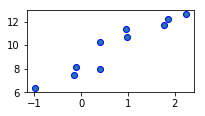

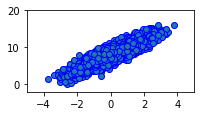

In [6]:
import pylab
%matplotlib inline

X, Y = gen_data(10)
pylab.figure(figsize=(3, 1.5))
pylab.scatter(X[:, 0], Y[:, 0], edgecolor='b')
pylab.show()

X, Y = gen_data(10000)
pylab.figure(figsize=(3, 1.5))
pylab.scatter(X[:, 0], Y[:, 0], edgecolor='b')
pylab.xlim([-5, 5])
pylab.ylim([-2, 20])
pylab.show()

In [7]:
def fit_model(nb_epoch, X, Y):
    N = X.shape[0]
    wr = l**2. / N
    dr = 2. / N
    model = Model(nb_features, wr, dr)
    model = model.cuda()
    optimizer = optim.Adam(model.parameters())
    
    for i in range(nb_epoch):
        old_batch = 0
        for batch in range(int(np.ceil(X.shape[0]/batch_size))):
            batch = (batch + 1)
            _x = X[old_batch: batch_size*batch]
            _y = Y[old_batch: batch_size*batch]
            
            x = Variable(torch.FloatTensor(_x)).cuda()
            y = Variable(torch.FloatTensor(_y)).cuda()
            
            mean, log_var, regularization = model(x)
                        
            loss = heteroscedastic_loss(y, mean, log_var) + regularization
             
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
    return model

In [8]:
def logsumexp(a):
    a_max = a.max(axis=0)
    return np.log(np.sum(np.exp(a - a_max), axis=0)) + a_max

def test(Y_true, K_test, means, logvar):
    """
    Estimate predictive log likelihood:
    log p(y|x, D) = log int p(y|x, w) p(w|D) dw
                 ~= log int p(y|x, w) q(w) dw
                 ~= log 1/K sum p(y|x, w_k) with w_k sim q(w)
                  = LogSumExp log p(y|x, w_k) - log K
    :Y_true: a 2D array of size N x dim
    :MC_samples: a 3D array of size samples K x N x 2*D
    """
    k = K_test
    N = Y_true.shape[0]
    mean = means 
    logvar = logvar
    test_ll = -0.5 * np.exp(-logvar) * (mean - Y_val.squeeze())**2. - 0.5 * logvar - 0.5 * np.log(2 * np.pi) #Y_true[None]
    test_ll = np.sum(np.sum(test_ll, -1), -1)
    test_ll = logsumexp(test_ll) - np.log(k)
    pppp = test_ll / N  # per point predictive probability
    rmse = np.mean((np.mean(mean, 0) - Y_val.squeeze())**2.)**0.5
    return pppp, rmse

In [9]:
def plot(X_train, Y_train, X_val, Y_val, means):
    indx = np.argsort(X_val[:, 0])
    _, (ax1, ax2, ax3, ax4) = pylab.subplots(1, 4,figsize=(12, 1.5), sharex=True, sharey=True)
    ax1.scatter(X_train[:, 0], Y_train[:, 0], c='y')
    ax1.set_title('Train set')
    ax2.plot(X_val[indx, 0], np.mean(means, 0)[indx], color='skyblue', lw=3)
    ax2.scatter(X_train[:, 0], Y_train[:, 0], c='y')
    ax2.set_title('+Predictive mean')
    for mean in means:
        ax3.scatter(X_val[:, 0], mean, c='b', alpha=0.2, lw=0)
    ax3.plot(X_val[indx, 0], np.mean(means, 0)[indx], color='skyblue', lw=3)
    ax3.set_title('+MC samples on validation X')
    ax4.scatter(X_val[:, 0], Y_val[:, 0], c='r', alpha=0.2, lw=0)
    ax4.set_title('Validation set')
    pylab.show()

2000


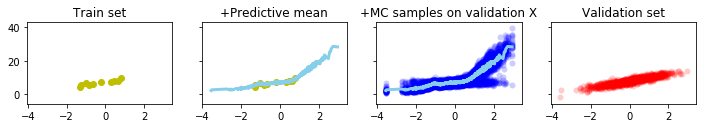

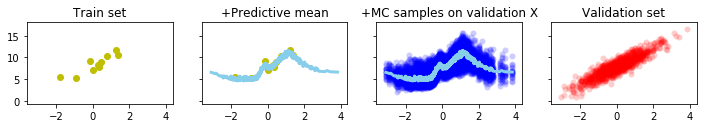

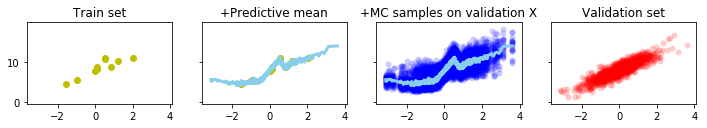

10 2000 - 1.9011648417770466 0.24303951008959393 [0.07610305 0.40353492 0.4032198  0.40342513 0.40377942]  -  1.2572105815607204 1.278382465200876
1000


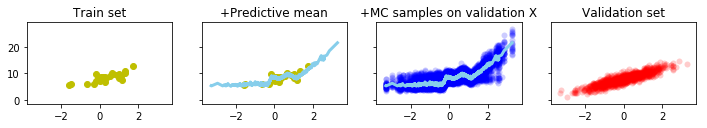

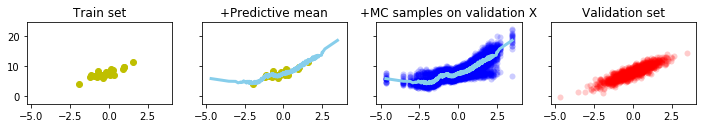

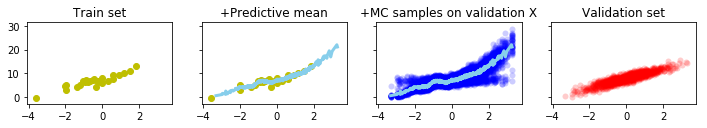

25 1000 - 1.348721899124622 0.0614880919240893 [0.07968374 0.40327868 0.40257165 0.4029567  0.40374103]  -  1.1986490692035765 1.081436875351575
500


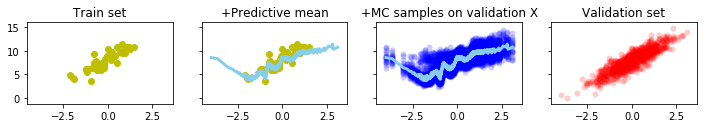

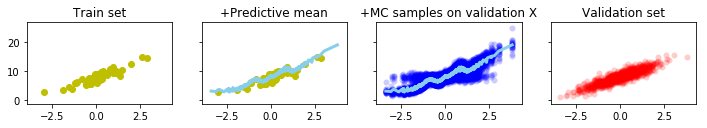

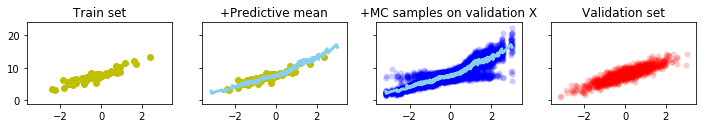

50 500 - 1.2378509657729342 0.04390610154622115 [0.06775161 0.32524806 0.32461116 0.32482925 0.32567415]  -  1.080847302456606 0.9038267623254048
200


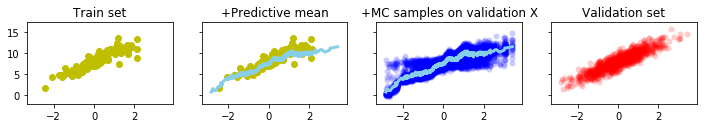

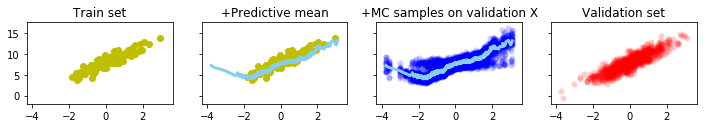

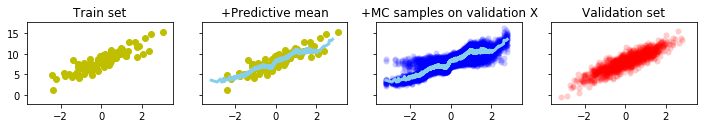

100 200 - 1.2576785488268312 0.04428810859498324 [0.07339317 0.23560779 0.23565508 0.23551978 0.23625855]  -  1.3172896502831961 0.7162933660031445
20


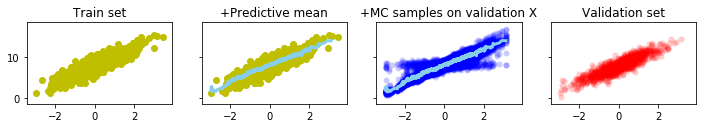

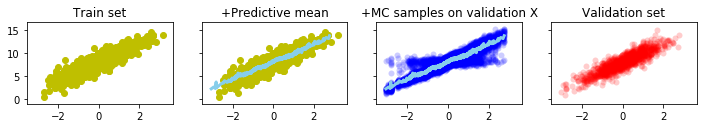

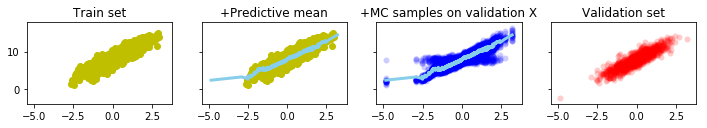

1000 20 - 1.0360106357407062 0.013881871744788025 [0.05576357 0.23161457 0.23222458 0.2317188  0.23595597]  -  1.22186897451959 0.643826070013147
2


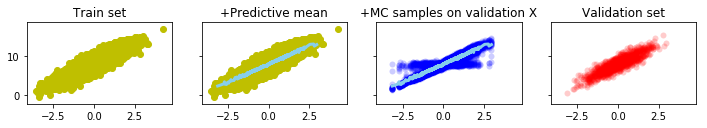

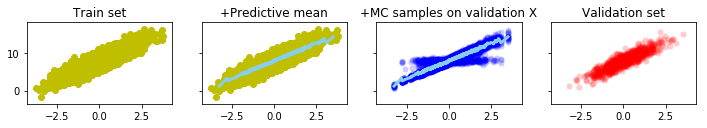

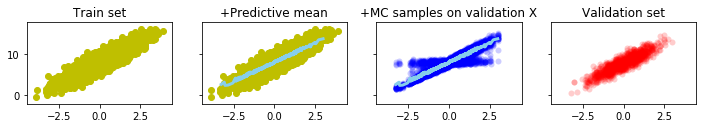

10000 2 - 1.0037328846108167 0.004725236028705939 [0.05109757 0.15658693 0.15775062 0.13618146 0.21885152]  -  1.1245151640640068 0.5308030436131737


In [10]:
results = []
for N, nb_epoch in zip(Ns, nb_epochs):
    rep_results = []
    print(nb_epoch)
    for i in range(nb_reps):
        X, Y = gen_data(N + nb_val_size)
        X_train, Y_train = X[:N], Y[:N]
        X_val, Y_val = X[N:], Y[N:]
        model = fit_model(nb_epoch, X_train, Y_train)
        model.eval()
        MC_samples = [model(Variable(torch.FloatTensor(X_val)).cuda()) for _ in range(K_test)]
        means = torch.stack([tup[0] for tup in MC_samples]).view(K_test, X_val.shape[0]).cpu().data.numpy()
        logvar = torch.stack([tup[1] for tup in MC_samples]).view(K_test, X_val.shape[0]).cpu().data.numpy()
        pppp, rmse = test(Y_val, K_test, means, logvar)
        epistemic_uncertainty = np.var(means, 0).mean(0)
        logvar = np.mean(logvar, 0)
        aleatoric_uncertainty = np.exp(logvar).mean(0)
        ps = np.array([torch.sigmoid(module.p_logit).cpu().data.numpy()[0] for module in model.modules() if hasattr(module, 'p_logit')])
        plot(X_train, Y_train, X_val, Y_val, means)
        rep_results += [(rmse, ps, aleatoric_uncertainty, epistemic_uncertainty)]
    test_mean = np.mean([r[0] for r in rep_results])
    test_std_err = np.std([r[0] for r in rep_results]) / np.sqrt(nb_reps)
    ps = np.mean([r[1] for r in rep_results], 0)
    aleatoric_uncertainty = np.mean([r[2] for r in rep_results])
    epistemic_uncertainty = np.mean([r[3] for r in rep_results])
    print(N, nb_epoch, '-', test_mean, test_std_err, ps, ' - ', aleatoric_uncertainty**0.5, epistemic_uncertainty**0.5)
    results += [rep_results]

In [11]:
import pickle
with open('concrete-dropout.pkl', 'wb') as f:
    pickle.dump(results, f)

In [12]:
best_tests = np.array([[r[0] for r in result] for result in results]).T
best_ps = np.array([[r[1] for r in result] for result in results])
best_aleatoric_uncertainty = np.array([[r[2] for r in result] for result in results]).T.squeeze()
best_epistemic_uncertainty = np.array([[r[3] for r in result] for result in results]).T.squeeze()
print(best_tests.mean(0))
print(best_ps.mean(1))

[1.90116484 1.3487219  1.23785097 1.25767855 1.03601064 1.00373288]
[[0.07610305 0.40353492 0.4032198  0.40342513 0.40377942]
 [0.07968374 0.40327868 0.40257165 0.4029567  0.40374103]
 [0.06775161 0.32524806 0.32461116 0.32482925 0.32567415]
 [0.07339317 0.23560779 0.23565508 0.23551978 0.23625855]
 [0.05576357 0.23161457 0.23222458 0.2317188  0.23595597]
 [0.05109757 0.15658693 0.15775062 0.13618146 0.21885152]]


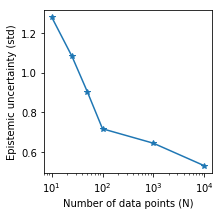

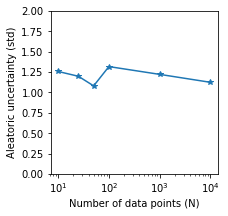

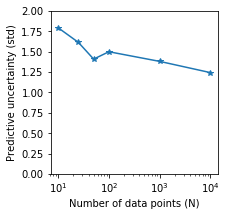

In [13]:
pylab.figure(figsize=(3, 3))
pylab.plot(Ns, np.mean(best_epistemic_uncertainty, 0)**0.5, '-*')
pylab.xlabel('Number of data points (N)')
pylab.ylabel('Epistemic uncertainty (std)')
pylab.xscale('log')
pylab.show()

pylab.figure(figsize=(3, 3))
pylab.plot(Ns, np.mean(best_aleatoric_uncertainty, 0)**0.5, '-*')
pylab.xlabel('Number of data points (N)')
pylab.ylabel('Aleatoric uncertainty (std)')
pylab.ylim([0, 2])
pylab.xscale('log')
pylab.show()

pylab.figure(figsize=(3, 3))
predictive = np.mean(best_epistemic_uncertainty, 0) + np.mean(best_aleatoric_uncertainty, 0)
pylab.plot(Ns, predictive**0.5, '-*')
pylab.xlabel('Number of data points (N)')
pylab.ylabel('Predictive uncertainty (std)')
pylab.ylim([0, 2])
pylab.xscale('log')
pylab.show()

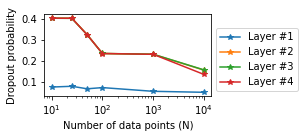

In [14]:
pylab.figure(figsize=(3, 1.5))
ps = best_ps.mean(1)
ps_std = best_ps.std(1)
for i, (p, p_std) in enumerate(zip(ps.T, ps_std.T)):
    if i == 4:
        continue  # layer 4 is noise layer
    pylab.plot(Ns, p, '-*', label='Layer #' + str(i+1))
pylab.legend(bbox_to_anchor=(1, 0), loc='lower left')
pylab.xlabel('Number of data points (N)')
pylab.ylabel('Dropout probability')
pylab.xscale('log')
pylab.show()